## Introduction
MapReduce version of Expectation Maximization of Gaussian Mixture Models (GMM). GMM/EM is a soft-classification clustering method. In general points in a sample set are considered as belonging to a mixture of Gaussian Distributions with unknown parameters. Each distribution represents a classification group and each point will be attributed some fraction of each Gaussian model. Hence GMMs incorporate information about the covariance of the data as well as cluster centers.

EM is a parallelizable algorithm that is used to find maximum likelihood parameters of unknown (latent) models. Mixture models assume that with each observed data point, there are also corresponding latent (unobserved) data points. Unlike most methods we've seen previously where we have hypothesized a model to fit a sample set, here we are extracting a model (of unknown paramters) from the data.

### Expectation Step (reassignment step)
Given priors, vector of means, and covariance matrix, calculate the probability that each data point belongs to a class for all classes.

### <center>$ p(\omega_k | \mathbf{x}^{(i)}, \theta) = \frac{\pi_k  N(\mathbf{x}^{(i)} | \mathbf{\mu_k}, \mathbf{\Sigma_k})}{\sigma_{j=1}^K \pi_j) | N(\mathbf{x}^{(i)} | \mu_j, \mathbf{\Sigma}_j)}$</center>

Where $\omega_k$ is the $k^{th}$ cluster, $\mathbf{x}^{(i)}$ = vector of data points/ features for sample $i$, $\theta$ is a parameter of the unknown model, $\pi_k$ is the prior to cluster $k$, $ N(\mathbf{x}^{(i)}| \mathbf{\mu_k}, \mathbf{\Sigma_k})$ is the hyperdimensional Gaussian distribution of sample $\mathbf{x}^{(i)}$ given a multivariate vector of means $\mu_k$ and covariance matrix $\mathbf{\Sigma_k}$.

### Maximization Step (update step)

Given the posteriors of this iteration, recompute the priors, means, and covariance.

### (1) <center>$\mathbf{\hat{\mu}_k} = \frac{1}{\mathbf{n_k}}\Sigma_{i=1}^n p(\omega_k|\mathbf{x}^{(i)}, \theta)(\mathbf{x}^{(i)})$ </center>

### (2)<center>$\mathbf{\hat{\Sigma}_k} = \frac{1}{\mathbf{n_k}}\Sigma_{i=1}^n p(\omega_k|\mathbf{x}^{(i)}, \theta)(\mathbf{x}^{(i)} - \hat{\mu}_k)(\mathbf{x}^{(i)} - \mathbf{\hat{\mu}_k})^T$</center> 

### (3)<center>$\hat{\pi}_k = \frac{\mathbf{n_k}}{\mathbf{n}}$ *where* $\mathbf{n}_k = \Sigma_{i=1}^n p(\omega_k|\mathbf{x}^{(i)}, \theta) $</center>

In [6]:
# Generate Data
%matplotlib inline
import numpy as np
import pylab
import json

size1 = size2 = size3 = 1000

# random datasets with same means and different covariance matrices
# create clusters in 3 different locations with variances
samples1 = np.random.multivariate_normal([4, 0], [[1,0], [0,1]], size1)
samples2 = np.random.multivariate_normal([6,6], [[1,0],[0,1]], size2)
samples3 = np.random.multivariate_normal([0,4], [[1,0],[0,1]], size3)

#append these datasets -> 3000 rows, 2 columns
data = samples1
data = np.append(data, samples2, axis=0)
data = np.append(data, samples3, axis=0)

# randomize the data
data = data[np.random.permutation(size1 + size2 + size3),]

# save the data
with open("data.txt", "w") as f:
    for row in data.tolist():
        json.dump(row,f) # serialize the data into json formatted stream
        f.write("\n") #end each row with new line


## Data Visualiazation

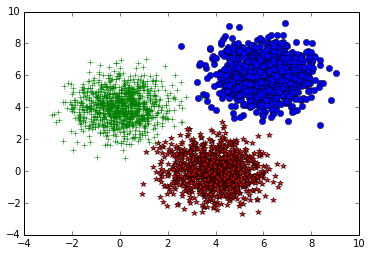

In [7]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

# Initialization Step (Maximization)

Assuming there are 3 clusters (from the visualization)

In [8]:
%%writefile MR_GMM_EM_Initialize.py
from mrjob.job import MRJob

from numpy import mat, zeros, shape, random, array, zeros_like, dot, linalg
from random import sample
import json
from math import pi, sqrt, exp, pow

class MrGmmEmInit(MRJob):
    #input stream format is json serialization
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGmmEmInit, self).__init__(*args, **kwargs)
        
        self.numMappers = 1
        self.count = 0
        
    def configure_options(self):
        super(MrGmmEmInit, self).configure_options()
        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermedateResults.txt is stored')
    
    def mapper(self, key, xjIn): #what is xjIn? sample initialize?
        # something simple to grab random starting point
        # collect the first 2k
        # output an initial value for each 2*k num of clusters
        if self.count <= 2*self.options.k:
            self.count += 1
            yield (1,xjIn) 
    
    def reducer(self, key, xjIn):
        
        # list of centers?
        cent = []
        for xj in xjIn:
            # converts string/json bytestream into object (list in this case)
            x = json.loads(xj) 
            # list of coordinates
            cent.append(x)
            yield 1, xj
            
        index = sample(range(len(cent)), self.options.k)
        cent2 = []
        for i in index:
            # randomize order of coordinate pairs
            cent2.append(cent[i])
            
        # use the covariance of the selected centers as 
        # the starting guess for covariances
        # First, calculate mean of centers
        mean = array(cent2[0])
        for i in range(1,self.options.k):
            mean = mean + array(cent2[i])
        mean = mean/float(self.options.k)
        
        
        # Second, accumulate the deviations
        cov = zeros((len(mean), len(mean)), dtype = float)
        for x in cent2:
            # "x minus mean"
            xmm = array(x) - mean
            for i in range(len(mean)):
                # the maximization step for covariance
                # sum of probability of wk given data * (x-uk)**2
                cov[i,i] = cov[i, i] + xmm[i]*xmm[i]
        
        # divide by 1/n
        cov = cov/(float(self.options.k)) 
        
        # Invert the covariance matrix to compute the 
        # probability density of a point from Gaussian dist
        covInv = linalg.inv(cov)
        cov_1 = [covInv.tolist()]*self.options.k
        
        # debugging dumps
        jDebug = json.dumps([cent2,mean.tolist(),cov.tolist(), covInv.tolist(),cov_1])    
        debugPath = self.options.pathName + 'debug.txt'
        fileOut = open(debugPath,'w')
        fileOut.write(jDebug)
        fileOut.close()
        
        # Third, start guessing at pi's - prior probabilities
        # initialize them all with the same number - 1/k - equally probably for each cluster
        pi = zeros(self.options.k, dtype = float)
        
        for i in range(self.options.k):
            pi[i] = 1.0/(float(self.options.k))
            
        # form output object
        # output each of three parameters we recalculated
        # prior, means, covariance
        outputList = [pi.tolist(), cent2, cov_1]
        
        # save as intermediateresults.txt
        jsonOut  = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == "__main__":
    MrGmmEmInit.run()


Overwriting MR_GMM_EM_Initialize.py


## Iteration Step(s) of EM

**Mapper** - each mapper needs k vector means and covariance matrices to make probability calculations (hence the init step). Can also accumulate partial sum (sum restricted to the mappers's input) of quantities required for the update step.  Then it emits partials sums as a single output to the combiner.

i.e. emit(dummy_key, partial_sum_for_all_k's)

**Reducer**--the iterator pulls in partial sums for all posterior probability calculations from all mappers and combines in a single reducer. In this case the reducer emits a single (json'd python object) with the new means and covariances.

i.e. emit(json.dumps([means, covariances]))

In [18]:
%%writefile mr_GmmEmIterate.py
from mrjob.job import MRJob

from math import sqrt, exp, pow, pi # note the var names
from numpy import zeros, shape, random, array, zeros_like, dot, linalg
import json

def gauss(x, mu, P_1):
    """
    determine the pdf of the Gaussian distribution
    https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    """
    xtemp = x - mu
    n = len(x)
    p = exp(-0.5*dot(xtemp,dot(P_1, xtemp))) #the exp term
    detP = 1/linalg.det(P_1) #recipricol of determinant of cov matrix
    p = p/(pow(2.0*pi, n/2.0)*sqrt(detP))
    return p #probability

class MrGmmEmIter(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGmmEmIter, self).__init__(*args, **kwargs)
        
        # read in intermediate results from either
        # initiator or iterating while loop
        fullPath = self.options.pathName + "intermediateResults.txt"
        fileIn = open(fullPath)
        inputJson = fileIn.read()
        fileIn.close()
        inputList = json.loads(inputJson)
        
        # intermediate results have list of prios, means, cov
        temp = inputList[0]
        self.phi = array(temp)      #prior class probabilities
        temp = inputList[1]
        self.means = array(temp)    #current means list
        temp = inputList[2]
        self.cov_1 = array(temp)    #inverse covariance matrices for w, calc.

        # accumulate partial sums
        # sum of weights by cluster
        # instantiate arrays of 0s with same dimensions as given arrays
        self.new_phi = zeros_like(self.phi) #partial weighted sum of weights
        self.new_means = zeros_like(self.means)
        self.new_cov = zeros_like(self.cov_1)
        
        self.numMappers =  1  # why 1?
        self.count = 0        #passes through mapper
        
    def configure_options(self):
        # overwrite configure_options method of base class
        super(MrGmmEmIter, self).configure_options()
        
        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default = "",
            type='str', 
            help='pathName: pathname where intermediateResults.txt is stored')
    
    def mapper(self, key, val):
        """ accumulate partial sums for each mapper
        """
        xList = json.loads(val)
        x = array(xList)
        wtVect = zeros_like(self.phi)
        
        # Loop will loop over all the three gaussion models which are part of the mixture model.
        # Each Gaussian has its own mean vector and a covariance matrix
        # The function gauss computes the probability density function (pdf)
        # for a mean vectore, self.means
        # and covariance matrix, self.cov_1* at a point x(2 dimensional in our case).
        # See equation (1)
        
        # Weights are computed for each of the clusters
        # See quation (4)
        for i in range(self.options.k):
            wtVect[i] = self.phi[i]*gauss(x, self.means[i], self.cov_1[i])
        
        wtSum = sum(wtVect)
        wtVect = wtVect/wtSum
        
        #accumulate to update estimate of probability density function
        # increment the count
        self.count += 1
        
        # accumulate weights for phi estimate
        self.new_phi  = self.new_phi +wtVect
        
        for i in range(self.options.k):
            # for each cluster, accumulate weights x's for mean calculation 
            # See equation (2)
            self.new_means[i] = self.new_means[i] + wtVect[i]*x
            #accumulate weighted squares for cov estimate
            xmm = x - self.means[i]
            covInc = zeros_like(self.new_cov[i])
            
            #for each cluster, accumulate the covariance matrix 
            # See equation(3)
            
            for l in range(len(xmm)):
                for m in range(len(xmm)):
                    covInc[l][m] = xmm[l]*xmm[m]
                self.new_cov[i] = self.new_cov[i] + wtVect[i]*covInc
            #dummy yield - real output passes to mapper_final in self
        
        
    def mapper_final(self):
        # For each data-point (2-D data here), the following is yielded from the mapper
        # count, phi(weights), mean vector, covariance matrix
        out = [self.count, 
               (self.new_phi).tolist(), 
               (self.new_means).tolist(), 
               (self.new_cov).tolist()
              ]
        jOut = json.dumps(out)
        
        yield 1, jOut
        
        
    ## REDUCER ##
    # Accumulate partial stats to be able to compute the mean vector, covariance matrix
    # and the weight vector of priors (phi)
    def reducer(self, key, xs):
        # accumulate partial sums
        first = True
        #xs gives us a list of partial stats, including count, phi, mean, and covariance.
        #Each stat is k-length array, storing info for k components
        for val in xs:
            if first:
                # if first for this cluster
                # then instantiate arrays for each stat
                # else accumulate them
                temp = json.loads(val)
                #totCount, totPhi, totMeans, and totCov are all arrays
                totCount = temp[0]
                totPhi = array(temp[1])
                totMeans = array(temp[2])
                totCov = array(temp[3])
                first = False
            else:
                temp = json.loads(vals)
                #cumulative sum of four arrays
                totCount = totCount + temp[0]
                totPhi = totPhi + temp[1]
                totMeans = totMeans + array(temp[2])
                totCov = totCov + array(temp[3])
                
        # finish calc of new probability parameters.
        # --array divided by array
        
        # New Priors:
        newPhi = totPhi/totCount
        
        #initialize these to something handy to get the right size arrays
        newMeans = totMeans
        newCov_1 = totCov
        
        #Computation of the new mean vector and new cov matrix for each cluster in the mixture model
        for i in range(self.options.k):
            newMeans[i,:] = totMeans[i,:]/totPhi[i]
            tempCov = totCov[i, :, :]/totPhi[i]
            
            # now invert the cov matrix
            # doing it here saves us from having to do a matrix 
            # inversion with every input data point
            newCov_1[i,:,:] = linalg.inv(tempCov)
            
        outputList = [newPhi.tolist(), newMeans.tolist(), newCov_1.tolist()]
        jsonOut = json.dumps(outputList)
        
        #write new parameters to file
        # to be cycled through until stop-condition is met
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    MrGmmEmIter.run()
                
        

Overwriting mr_GmmEmIterate.py


## Driver

Iteration0
[[6.397859959040291, 5.554041426330523], [3.6864803871103207, 0.1210623998349072], [6.048275401669092, 6.7517978321467425]]


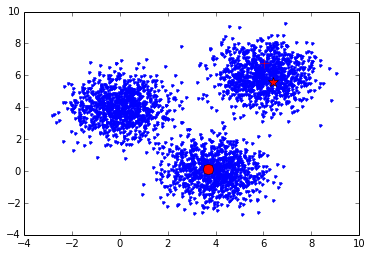

Iteration1
[[6.040383210982424, 5.323424801785208], [1.8766516457081623, 2.178284930920351], [5.851371476397305, 5.730761535813595]]


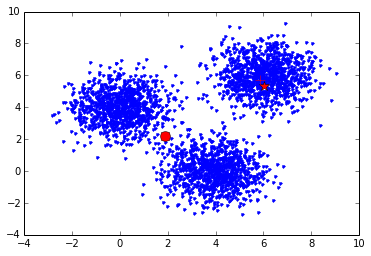

Iteration2
[[5.9346114700594335, 5.638382537551431], [1.9195759281737994, 2.0541426152492552], [5.840108078165537, 5.894339624392119]]


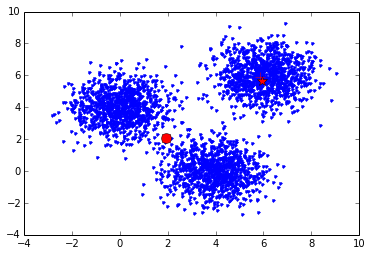

Iteration3
[[5.9348687564945495, 5.880759017153564], [1.9681971730852403, 2.0061248570382832], [5.8765689673602886, 6.037103872858304]]


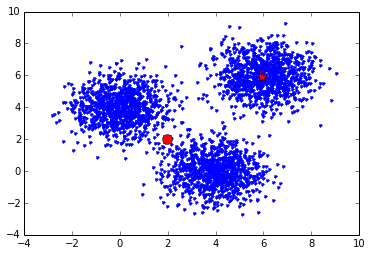

Iteration4
[[5.910687654164632, 5.938573849177691], [1.9826993605696417, 1.9951156472474014], [5.88232318959211, 6.061483919149042]]


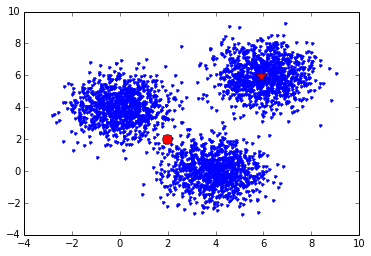

Iteration5
[[5.890495012366393, 5.948789467901953], [1.9869974661739636, 1.9909625172321963], [5.879855406880295, 6.063034553984975]]


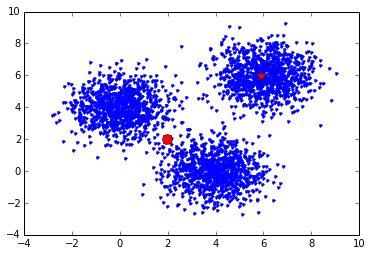

Iteration6
[[5.874920728798418, 5.951155335832355], [1.988722614713392, 1.9870581021185802], [5.872470766713129, 6.059928027583462]]


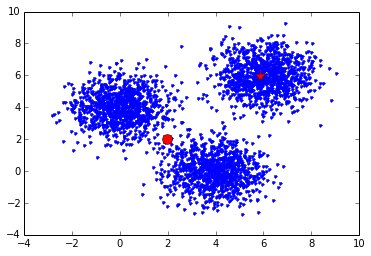

Iteration7
[[5.8600820200362636, 5.951678667816633], [1.9900974928703212, 1.982657735123759], [5.861866515293196, 6.05600124226314]]


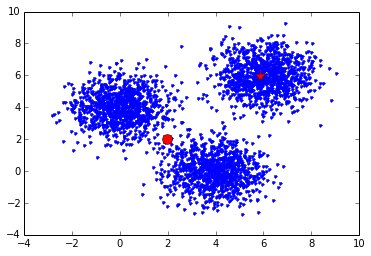

Iteration8
[[5.843408604679012, 5.95119460801146], [1.991665783446356, 1.977495107752386], [5.848691791790599, 6.051819653786711]]


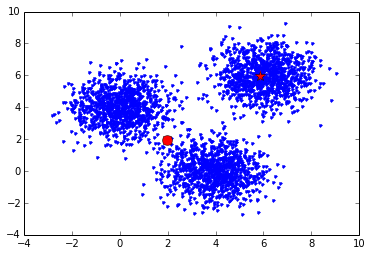

Iteration9
[[5.822565479778972, 5.94960749210385], [1.993669070673868, 1.9712012459415094], [5.832831759521665, 6.0473509848999445]]


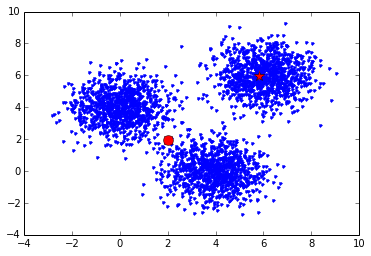

Iteration10
[[5.794224912730158, 5.946422983981485], [1.996387894330999, 1.9631932349588466], [5.813826837665273, 6.042442630437485]]


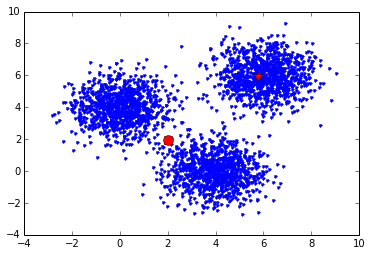

Iteration11
[[5.75234675939475, 5.940566735710988], [2.000295796481706, 1.9525104936784519], [5.791290566249234, 6.036933029424175]]


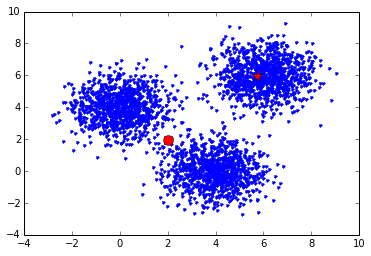

Iteration12
[[5.684638296991213, 5.92971584573549], [2.0062865449301155, 1.9374889025051043], [5.765723198078666, 6.03077885163937]]


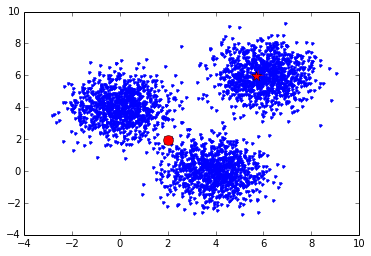

Iteration13
[[5.564581547814238, 5.908630167977307], [2.0161745704840204, 1.915121924794336], [5.74032154196212, 6.02437756763677]]


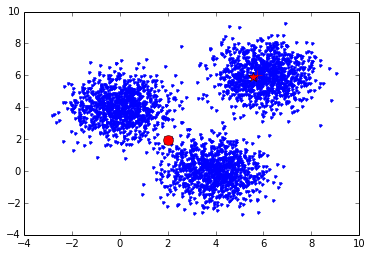

Iteration14
[[5.336558705003474, 5.8655482968036], [2.033725536880896, 1.8801249542408283], [5.723646605253796, 6.019216683941785]]


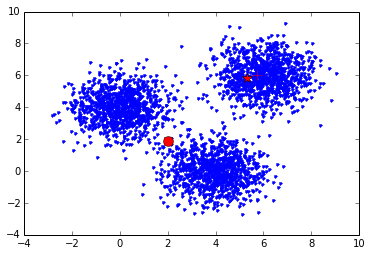

Iteration15
[[4.911919296580806, 5.778836774842476], [2.065255185474447, 1.8259659953540155], [5.728195831762727, 6.018296493678802]]


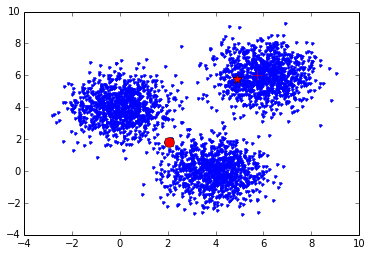

Iteration16
[[4.255227472705327, 5.631838672479003], [2.112763343432242, 1.7556739737950462], [5.756700334748932, 6.0240972702112865]]


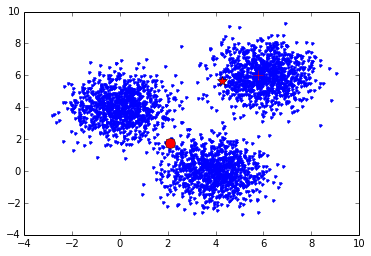

Iteration17
[[3.516511182506728, 5.451255526061696], [2.1608293121133246, 1.6919419666527589], [5.796399812002684, 6.035047157706141]]


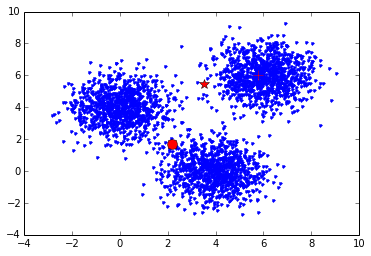

Iteration18
[[2.8976082607606775, 5.290160521795307], [2.1935565021398205, 1.6508366441257223], [5.839281956649689, 6.048390183397841]]


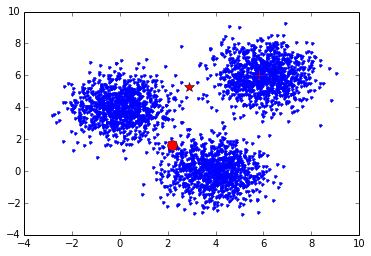

Iteration19
[[2.4564200147193707, 5.170558811175002], [2.2135384912513514, 1.6262117739702875], [5.88524347870373, 6.063425756445146]]


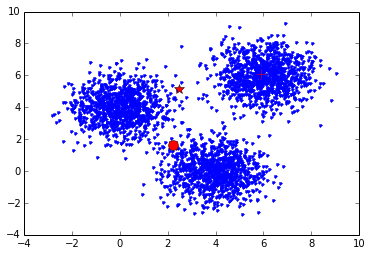

Iteration20
[[2.1488550706279845, 5.085461501326524], [2.2286720496570034, 1.6076911089557038], [5.9312261735240055, 6.078491150506897]]


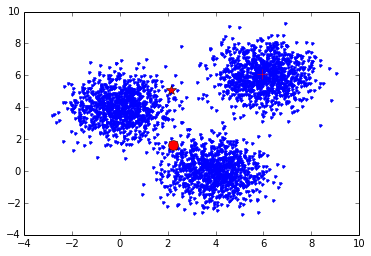

Iteration21
[[1.9260982681913, 5.023346518125371], [2.243446499380051, 1.5894250425925942], [5.969934762653917, 6.091075963681274]]


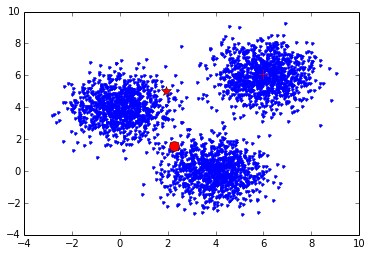

Iteration22
[[1.7602181127062466, 4.975548602198304], [2.2595020676801867, 1.5690505176585683], [5.99599492165088, 6.10011661330478]]


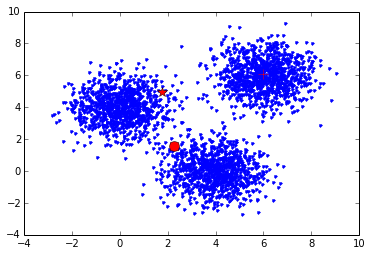

Iteration23
[[1.6355263408061769, 4.936344415250039], [2.2771107251932823, 1.5462251442989534], [6.010384981865089, 6.106431291092339]]


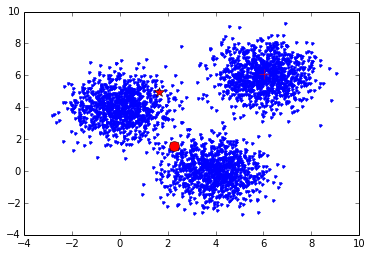

Iteration24
[[1.540510856391391, 4.902425565973282], [2.2961050625683397, 1.521460896074899], [6.017491712300142, 6.111305389394658]]


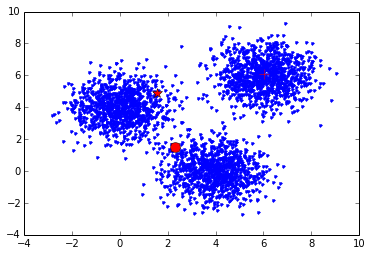

Iteration25
[[1.4663886771784456, 4.872130488035227], [2.316257793471305, 1.49536225865607], [6.021002791789927, 6.1155796337960275]]


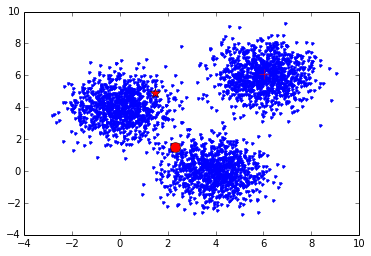

Iteration26
[[1.4070649478294341, 4.844638778282808], [2.3373502608545316, 1.4683962921241458], [6.0229589674555815, 6.119645895889462]]


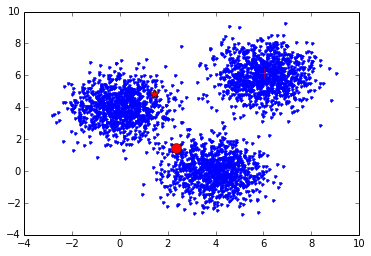

Iteration27
[[1.3584788767089901, 4.8194885550020965], [2.35916856979058, 1.4409137050610863], [6.024285390478052, 6.123643654361721]]


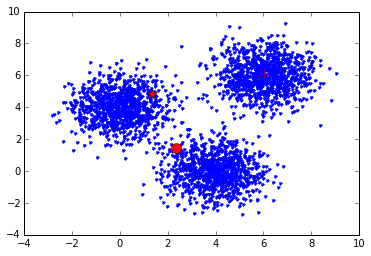

Iteration28
[[1.3178992177765723, 4.796376514169676], [2.3814985245723927, 1.41320499068148], [6.025354611987593, 6.127596463708045]]


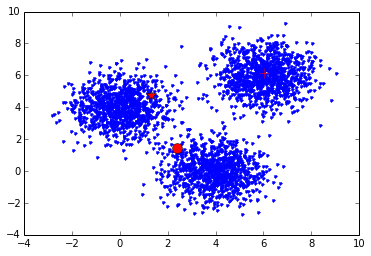

Iteration29
[[1.2834343080001114, 4.775082875951335], [2.4041280258241597, 1.3855291182033211], [6.026302546198545, 6.131481097995427]]


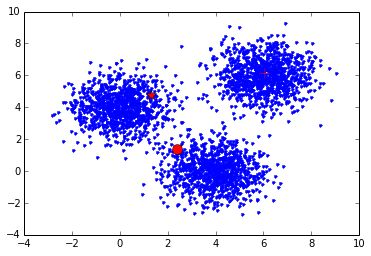

Iteration30
[[1.2537290362970717, 4.755438259676628], [2.4268535745071986, 1.358119526937707], [6.027173297715108, 6.1352588116887725]]


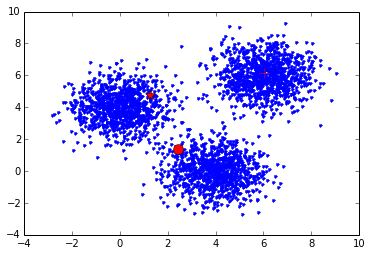

Iteration31
[[1.2277819420331135, 4.737304501832255], [2.4494874948249343, 1.3311808295227652], [6.02797940282718, 6.138889160896463]]


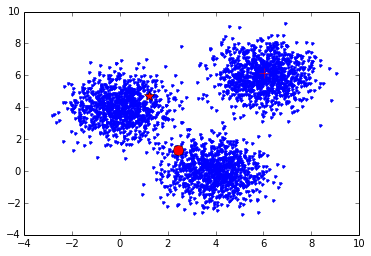

Iteration32
[[1.2048337750358784, 4.720561788041387], [2.4718639930988493, 1.3048842088793582], [6.0287249259720435, 6.14233632488981]]


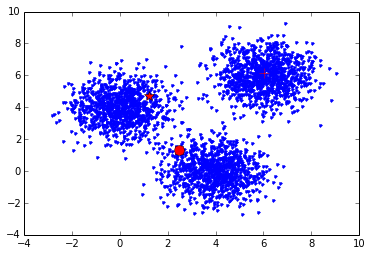

Iteration33
[[1.1842976651446637, 4.705100234746321], [2.4938432028472857, 1.279364751305544], [6.029413172699524, 6.145572003956102]]


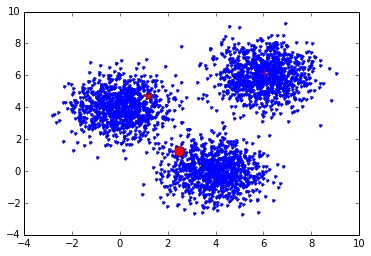

Iteration34
[[1.1657135461903796, 4.690815151425169], [2.5153130155571475, 1.2547214317505408], [6.03004844814361, 6.1485764507111424]]


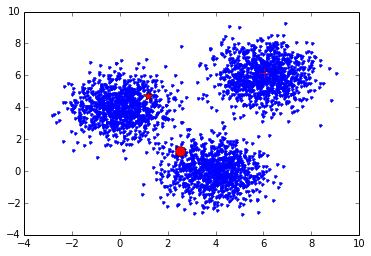

Iteration35
[[1.1487169905283174, 4.677605121701067], [2.5361889182860593, 1.2310193640129825], [6.030635832588975, 6.15133831012123]]


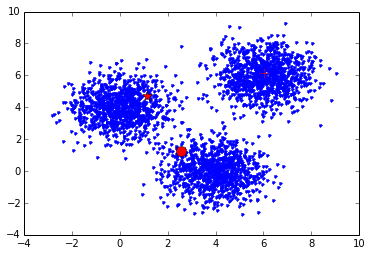

Iteration36
[[1.1330169329994353, 4.665371902010751], [2.5564122935107023, 1.2082935726345734], [6.031180555415848, 6.1538536926126195]]


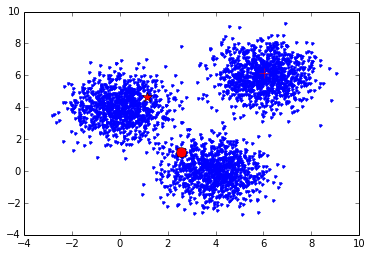

Iteration37
[[1.1183791724955068, 4.654021217210336], [2.5759477104000634, 1.1865535446306952], [6.031687506084118, 6.156124827492189]]


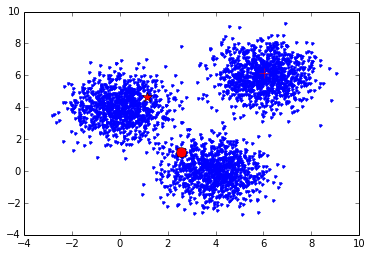

Iteration38
[[1.1046138476319123, 4.643463776167911], [2.594779696484997, 1.1657879664950765], [6.032160987448297, 6.158158579903251]]


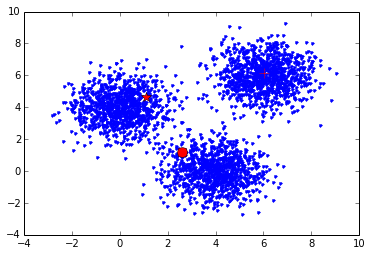

Iteration39
[[1.0915657839916177, 4.633616111351233], [2.6129093781133226, 1.1459692349512713], [6.0326046625279846, 6.159965034357739]]


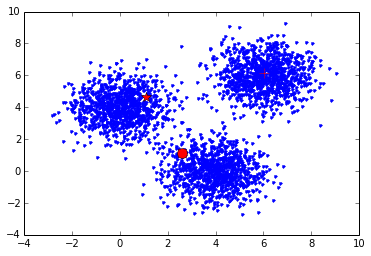

Iteration40
[[1.0791069898265697, 4.624401077274491], [2.6303512611211484, 1.1270574962034292], [6.033021613965678, 6.161556264679893]]


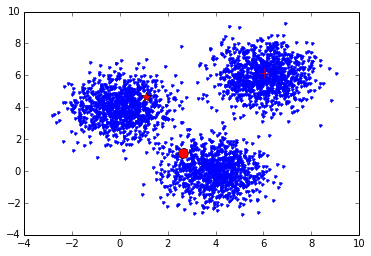

Iteration41
[[1.067130791841279, 4.615747992577327], [2.647130317171863, 1.109004097942531], [6.033414449478652, 6.162945340333697]]


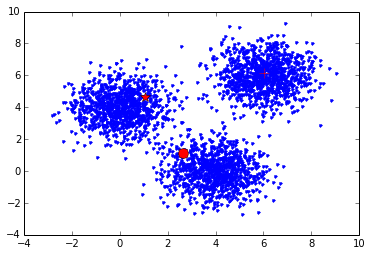

Iteration42
[[1.0555472341934065, 4.60759248665075], [2.663279458292532, 1.0917544283943674], [6.033785411340731, 6.164145570354799]]


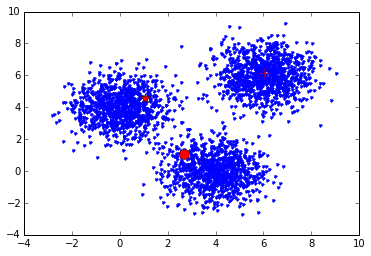

Iteration43
[[1.04427945230055, 4.599876136383206], [2.6788374240539015, 1.075250172679762], [6.03413646923746, 6.165169958091559]]


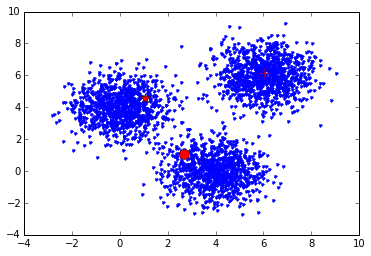

Iteration44
[[1.033260797448552, 4.592545974297653], [2.693847069123633, 1.0594310468462222], [6.034469390022226, 6.166030828005222]]


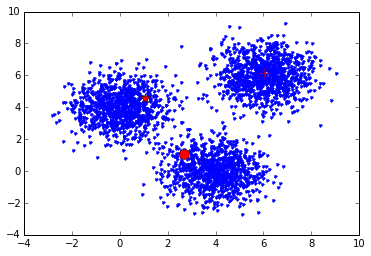

Iteration45
[[1.0224325374168708, 4.585553932660162], [2.7083540183907715, 1.0442360821214236], [6.034785785618556, 6.166739584227133]]


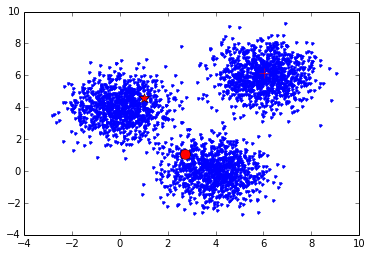

Iteration46
[[1.0117419966747132, 4.578856268960043], [2.722405647555477, 1.0296045328120158], [6.03508714352196, 6.167306564622631]]


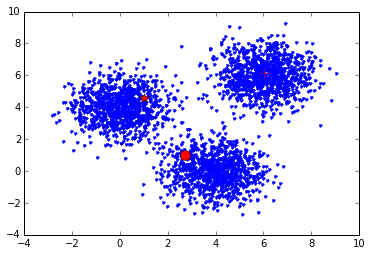

Iteration47
[[1.001141029555855, 4.572413001264128], [2.736050345020892, 1.0154764756798837], [6.035374844924899, 6.167740960393675]]


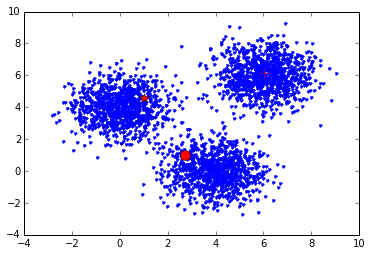

Iteration48
[[0.9905847427996426, 4.566187368922018], [2.7493370132343506, 1.001793159860951], [6.035650174797193, 6.168050777756992]]


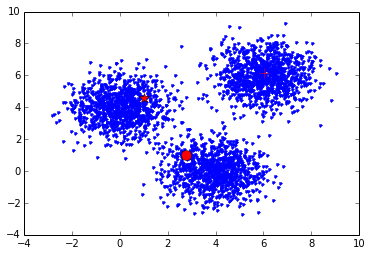

Iteration49
[[0.9800304012171873, 4.560145324883237], [2.762314772354258, 0.9884971565091261], [6.035914327138678, 6.168242823947135]]


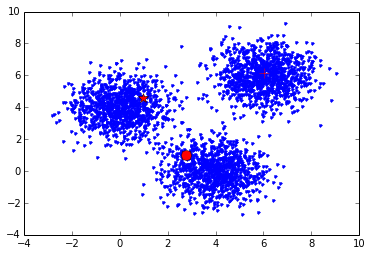

Iteration50
[[0.9694364630535786, 4.5542550597573905], [2.7750328350333664, 0.9755323475293785], [6.036168407515247, 6.168322704331195]]


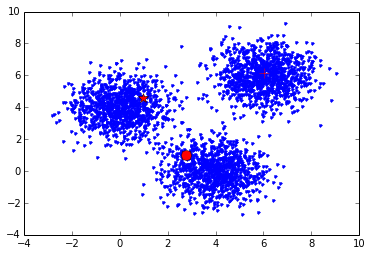

Iteration51
[[0.9587617007255677, 4.548486553838852], [2.7875405274711307, 0.962843783596026], [6.036413434076883, 6.168294820761854]]


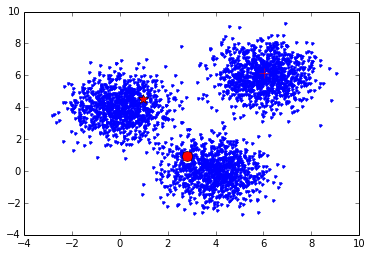

Iteration52
[[0.9479643686944924, 4.542811150855186], [2.7998874383135726, 0.9503774333463297], [6.036650337564724, 6.1681623635561085]]


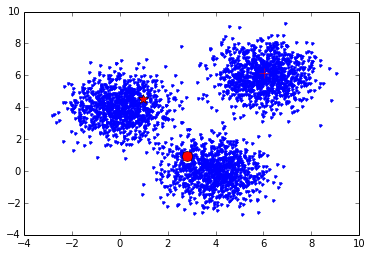

Iteration53
[[0.9370013837656762, 4.537201145572572], [2.812123683316536, 0.9380798381742761], [6.036879960317301, 6.1679272908411304]]


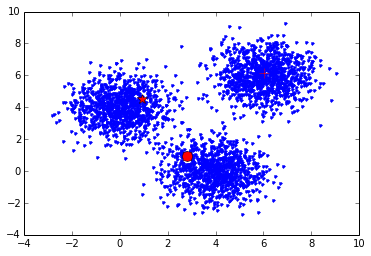

Iteration54
[[0.925827484389006, 4.531629376144435], [2.8243002799561254, 0.9258976802664841], [6.03710305391593, 6.167590289601623]]


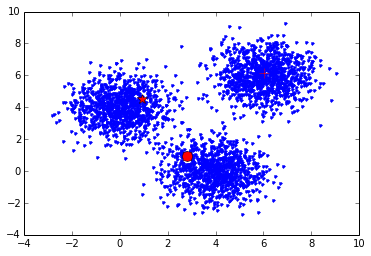

Iteration55
[[0.9143943346853393, 4.526068810878292], [2.8364696325108847, 0.9137772651763162], [6.037320274808989, 6.167150712701072]]


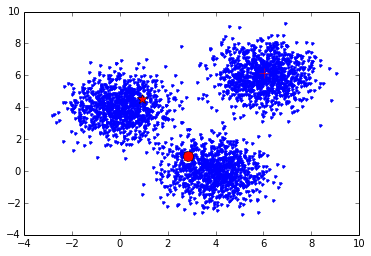

Iteration56
[[0.9026495358745069, 4.520492117650791], [2.8486861348050194, 0.9016639140167355], [6.037532176949224, 6.166606485469835]]


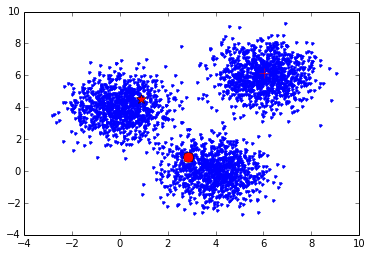

Iteration57
[[0.8905355022600173, 4.514871202280728], [2.8610069051504876, 0.8895012539014707], [6.037739200114318, 6.1659539741422815]]


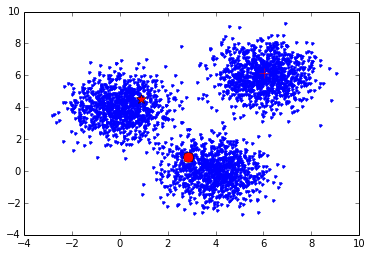

Iteration58
[[0.8779881504341691, 4.509176699525158], [2.8734926765459234, 0.8772303881392706], [6.0379416520710105, 6.165187806375885]]


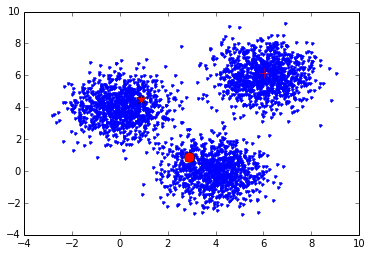

Iteration59
[[0.864935338100705, 4.503377396696465], [2.8862088755428617, 0.8647889193464258], [6.038139681997215, 6.164300631123855]]


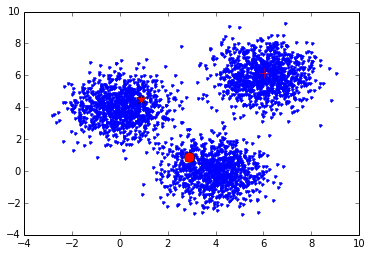

Iteration60
[[0.8512949716896622, 4.497439564820934], [2.8992269362756824, 0.8521097883975863], [6.038333241449457, 6.163282800951453]]


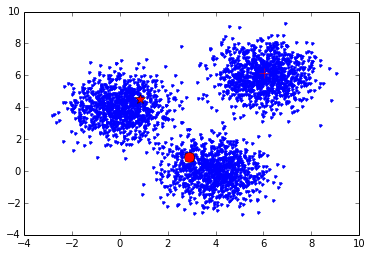

Iteration61
[[0.8369726780496096, 4.491326165238792], [2.9126259132151837, 0.839119879073533], [6.03852202743737, 6.162121954041416]]


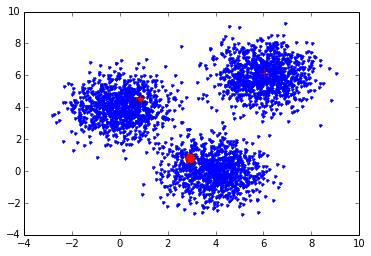

Iteration62
[[0.8218589025338509, 4.484995889837327], [2.9264944790059904, 0.8257383211599372], [6.038705399490055, 6.160802464956988]]


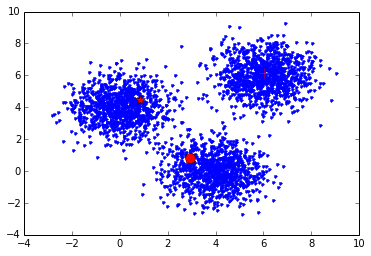

Iteration63
[[0.8058252503923699, 4.4784019796527135], [2.9409334247780343, 0.8118744019234414], [6.038882258391086, 6.159304721753979]]


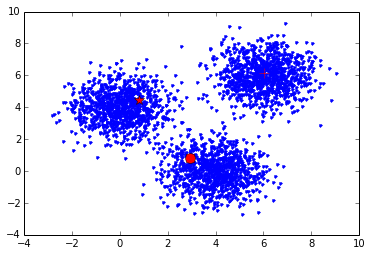

Iteration64
[[0.7887198259867324, 4.471490747877751], [2.9560588231747054, 0.7974249650301808], [6.03905086754511, 6.157604170874225]]


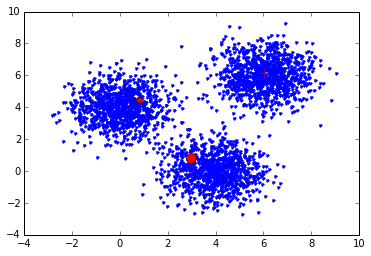

Iteration65
[[0.770361239071757, 4.464199707253147], [2.972006074191424, 0.7822711339198912], [6.039208587037785, 6.155670048445283]]


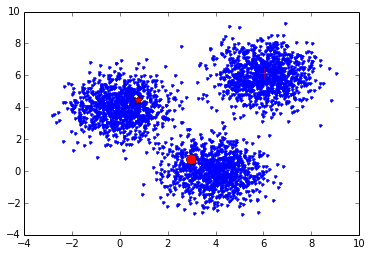

Iteration66
[[0.750530832340146, 4.456455165480384], [2.98893513821697, 0.7662741391811032], [6.039351472425381, 6.153463684517551]]


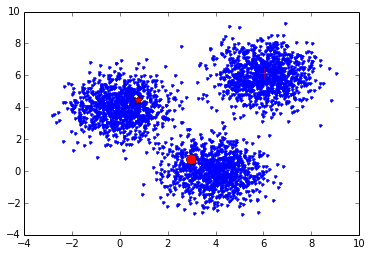

Iteration67
[[0.7289625335983333, 4.448169101781379], [3.0070373799876937, 0.7492699512380125], [6.039473659886018, 6.150936222100492]]


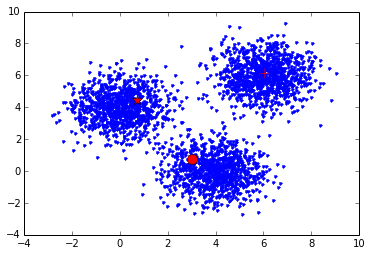

Iteration68
[[0.7053295504257224, 4.439235068329186], [3.026544615984883, 0.7310623147050324], [6.0395664070190564, 6.1480255324359705]]


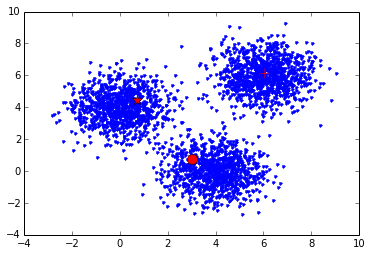

Iteration69
[[0.6792269311326461, 4.429522767574229], [3.0477411943626462, 0.7114136448990085], [6.039616566584661, 6.144652031541097]]


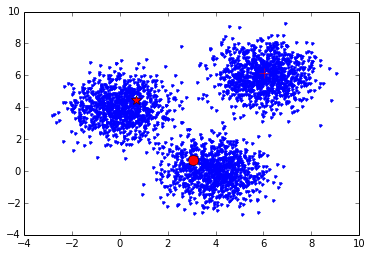

Iteration70
[[0.6501489138176015, 4.418870840538088], [3.0709802588065718, 0.6900330853019521], [6.039604105648264, 6.140713022335114]]


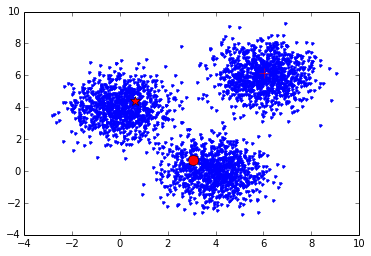

Iteration71
[[0.6174602828402541, 4.4070772791780595], [3.096705757181634, 0.6665608731517315], [6.039497982758857, 6.136075151402824]]


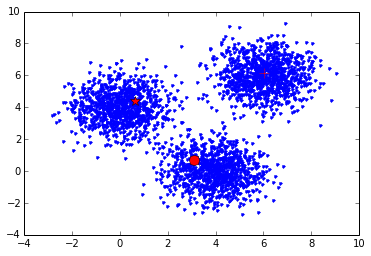

Iteration72
[[0.58036251741995, 4.393886819173073], [3.125482183040131, 0.6405481450997982], [6.039249147540653, 6.130564741426844]]


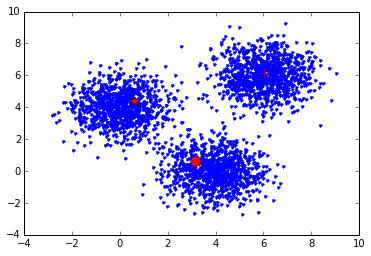

Iteration73
[[0.5378607142719414, 4.378974907623903], [3.1580341771706353, 0.6114318147487066], [6.038778443709284, 6.123956616905678]]


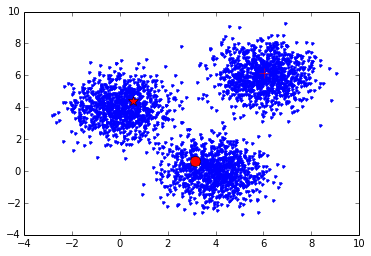

Iteration74
[[0.48875234469951007, 4.361929056803948], [3.1952969345217284, 0.5785062374613195], [6.037955576418753, 6.11596491200367]]


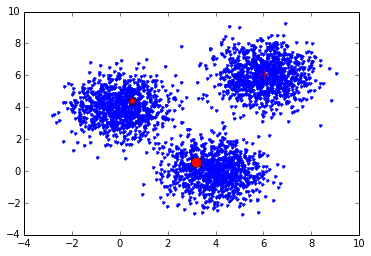

Iteration75
[[0.43169952025992825, 4.3422325562558735], [3.23847268304446, 0.5408999600351575], [6.036563400882872, 6.106247693959281]]


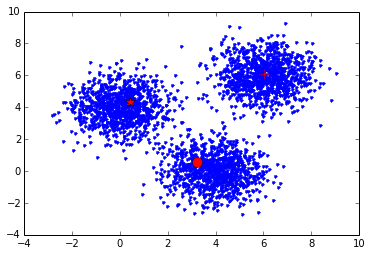

Iteration76
[[0.36554651119182513, 4.31926804422101], [3.289069121812141, 0.49758454657782347], [6.034243445242809, 6.094458817171173]]


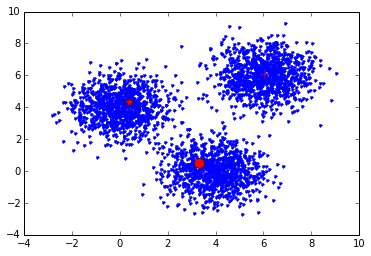

Iteration77
[[0.29024611115914134, 4.292392321703332], [3.3488382397138863, 0.44749108788319714], [6.030442234458924, 6.080426052851387]]


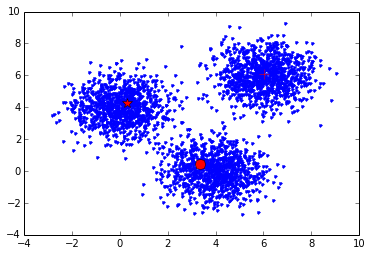

Iteration78
[[0.20893831009679292, 4.261204739821499], [3.41938786012963, 0.38991671073051476], [6.024478940091387, 6.0645840311186205]]


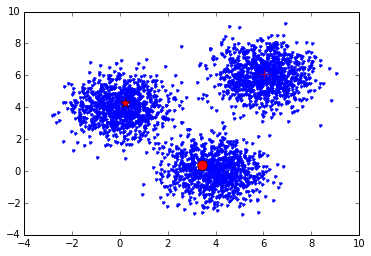

Iteration79
[[0.13080515025334713, 4.2261667003531915], [3.50098670912754, 0.3255314614788193], [6.016061912423498, 6.048629845214504]]


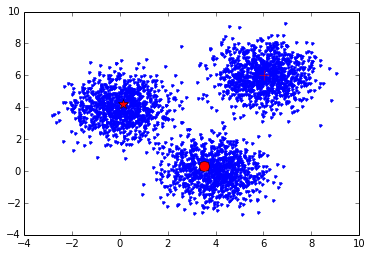

Iteration80
[[0.06993716658488108, 4.189269379054457], [3.5902317236132784, 0.25795337087834325], [6.006350003918637, 6.035471339933986]]


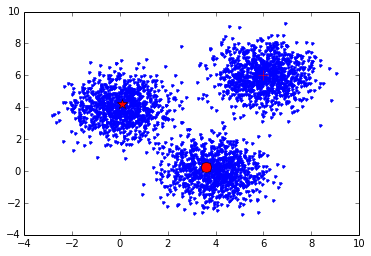

Iteration81
[[0.03442267564786153, 4.15335689191974], [3.678604985494498, 0.19398464748917063], [5.99792942391464, 6.027122329567834]]


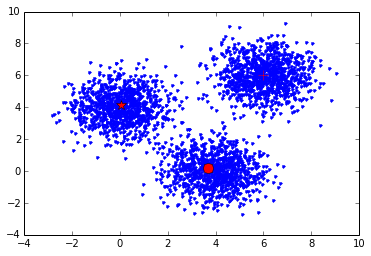

Iteration82
[[0.019450239023334696, 4.120425739961073], [3.756369702951723, 0.1401435101851984], [5.992533471482231, 6.022959308151032]]


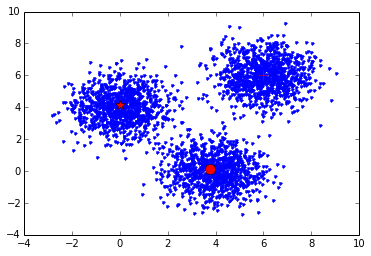

Iteration83
[[0.016085136338262897, 4.091787250099744], [3.8180802472219715, 0.09926149943695628], [5.989894123258405, 6.021194267186179]]


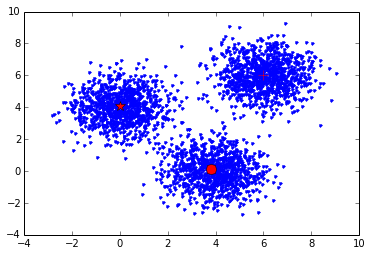

Iteration84
[[0.01815896986461983, 4.068964609036991], [3.8623423531978562, 0.07088373854488449], [5.98890661874933, 6.0205298809389545]]


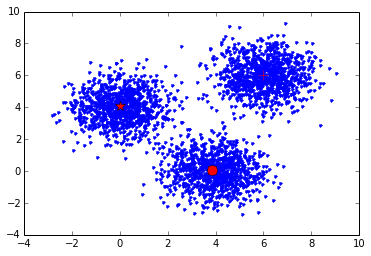

Iteration85
[[0.022226020912823965, 4.052961811805888], [3.890357847738346, 0.052904589995858044], [5.988670704406594, 6.020337123356696]]


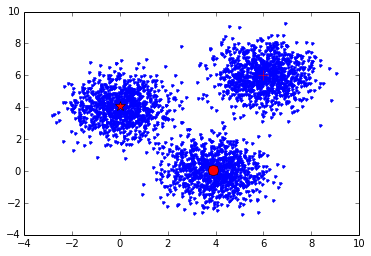

Iteration86
[[0.026261117347299398, 4.043035955691849], [3.906058828222257, 0.042463834361955013], [5.9886906248918725, 6.020343949757938]]


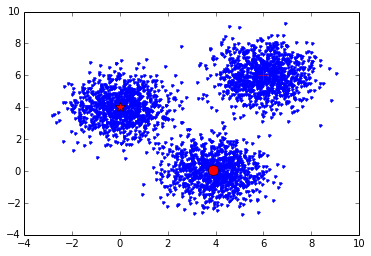

Iteration87
[[0.029374896966909862, 4.037391341770506], [3.9141800717734077, 0.03675224314508602], [5.988776031558273, 6.02042784431606]]


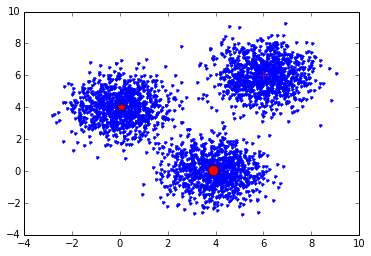

In [19]:
from MR_GMM_EM_Initialize import MrGmmEmInit
from mr_GmmEmIterate import MrGmmEmIter
import json
from math import sqrt
import os

def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1], '.', color = 'blue')
    pylab.plot(means[0][0],  means[0][1], '*', markersize=10, color='red')
    pylab.plot(means[1][0],  means[1][1], 'o', markersize=10, color='red')
    pylab.plot(means[2][0],  means[2][1], '+', markersize=10, color='red')
    pylab.show()

def dist(x,y):
    # euclidean distance between two lists
    sum = 0.0
    for i in range(len(x)):
        temp = x[i] - y[i]
        sum += temp * temp
    return sqrt(sum)

# First run the initializer to start centroid
work_dir = os.getcwd()
filePath = 'data.txt'
mrJob = MrGmmEmInit(args=[filePath, '--pathName', '/Users/safyre/Documents/w261_machine_learning'])
with mrJob.make_runner() as runner:
    runner.run()
    
# Pull out the centroid values to compare with values after initialization
emPath = "intermediateResults.txt"
fileIn = open(work_dir + emPath)
paramJson = fileIn.read()
fileIn.close()

# Prepare for iterations
delta = 10
iter_num = 0
#stop_condition = 0.02

# Begin EM Iterating
while delta > 0.02:
    print "Iteration" + str(iter_num)
    iter_num += 1
    
    #parse old centroid values
    oldParam = json.loads(paramJson)
    oldMeans = oldParam[1]
    #run one iteration of MRJob
    mrJob2 = MrGmmEmIter(args = [filePath, '--pathName', work_dir])
    with mrJob2.make_runner() as runner:
        runner.run()
        
    #compare new centroids to old ones
    fileIn = open(work_dir + emPath)
    paramJson = fileIn.read()
    fileIn.close()
    newParam = json.loads(paramJson)
    
    k_means = len(newParam[1])
    newMeans = newParam[1]
    
    delta = 0.0
    for i in range(k_means):
        delta += dist(newMeans[i], oldMeans[i])
    
    print oldMeans
    plot_iteration(oldMeans)

print "Iteration" + str(iter_num)
print newMeans
plot_iteration(newMeans)
    

After 87 iterations, the EM algorithm seems to have converged correctly at the centers of each cluster.  The final center points are (3.9, 0.0), (0.0, 4.0), and (6.0, 6.0) rounded. These are quite close to our initial values that we had used in our artificial dataset.

However, the first time this ran, the centers converged incorrectly.  The results seem to be sensitive to the starting coordinates of the centers which are chosen at random. If the starting points are way off course, the points may take over 100 iterations until convergence or prematurely stop (usually around 20-50 iterations) at nonsensical centers.